# Análisis de MAIAC
Objetivo: analizar el producto satelital MAIAC mediante distintas comparaciones y visualizaciones.


In [6]:
# Library
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import scipy.stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from math import sqrt
import os
from os import listdir
from datetime import datetime
import pandas as pd
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
print("librerias ok")

librerias ok


In [7]:
# Regresion lineal MAIAC vs AERONET
def linear_regression_plot (path, date_format,nrows,ncols,color_maiac, plot, resolucion_espaciotemporal):
    '''
La función permite graficar la regresión lineal de cada estación AERONET.
Además, se muestran las principales estadísticas y la ecuación de la regresión lineal.
Los datos de cada estación de interés se encuentran en una carpeta en formato .csv previamente procesados.
La función recorre esa carpeta y toma cada uno de esos archivos para generar la gráfica correspondiente.

Variables:
- path: ruta a la carpeta donde se encuentran los archivos en formato .csv.
- date_format: formato de la columna de fecha del archivo de interés.
  Por ejemplo: date_format='%Y-%m-%d %H:%M:%S'
- nrows: cantidad de filas que tendrá la grilla de gráficos.
- ncols: cantidad de columnas que tendrá la grilla de gráficos.
- color_modis: paleta de colores para las estaciones MODIS-MAIAC. Por ejemplo:
  color_modis = ["#74c476","#fed976","#fb6a4a", "#74a9cf","#df65b0","#807dba"]
- color_maiac: paleta de colores para las estaciones MAIAC. Por ejemplo:
  color_maiac = ["#005a32","#fd8d3c","#99000d","#023858","#ce1256","#3f007d"]
'''

    i=0 
    j=0 
    edge_color_maiac = color_maiac 
    fig, ax = plt.subplots(ncols=ncols,nrows=nrows,  figsize=(12,6),dpi=400)
    #Se recorre la carpeta donde estan los archivos ya procesados de cada estacion
    for p,files in enumerate(os.listdir(path)):
        print(p)
        N = len(os.listdir(path))
        data = pd.read_csv(os.path.join(path,files))
        # Se crea columna llamada "Timestamp".
        data["Timestamp"] = data["date"].apply(lambda x: datetime.strptime(x,date_format))
        # Se convierte en la columna Index
        data.set_index('Timestamp', inplace = True)
        data_mean_period_len =len(data.dropna(how='all'))
        # Nombre de la estacion
        station_name = files [2:4]
        ########################                VARIABLES                ########################
        
        # Revisar porque puede cambiar segun la version del archivo usado
        #y_maiac= data["AOD_550_maiac"]
        y_maiac= data["AOD_550_maiac_mean"]
        x= data["AOD_550_AER_mean"]
        # Control de nans
        mask = ~np.isnan(x) & ~np.isnan(y_maiac)
        x= x[mask]
        y_maiac = y_maiac[mask]
        
        #numero de datos sin contar los NaNs
        n = len(x)
        #Calculo de metricas: pendiente, la ordenada al origen y el R2
        slope_maiac , intercept_maiac , r_maiac , p_maiac , stderr_maiac  = scipy.stats.linregress(x , y_maiac)
        # R2                                                                                            
        R2_maiac=r_maiac*r_maiac

        #Calculo RMSE
        #RMSE_modis = mean_squared_error(y_modis, x, squared = True)
        #RMSE_maiac = mean_squared_error(y_maiac, x, squared = True)
        
        #RMSE_maiac = mean_squared_error(y_maiac, x, squared = False)
        RMSE_maiac = root_mean_squared_error(y_maiac, x)
        bias_maiac = round(( sum(y_maiac - x)/n),2)
                
        ########################                PREDICT                ########################
                   
        #y_maiac_p= data["AOD_550_maiac"].values.reshape(-1,1)
        y_maiac_p= data["AOD_550_maiac_mean"].values.reshape(-1,1)
        x_p= data["AOD_550_AER_mean"].values.reshape(-1,1)
        # Regresion lineal
        linear_regresion_maiac = LinearRegression()
        linear_regresion_maiac.fit(x_p,y_maiac_p)

        li_predict_maiac = linear_regresion_maiac.predict(x_p)
        #print(files)
        ########################                PLOT                ########################
 
        #ax[i][j].scatter(x, y_maiac,  c=color_maiac[p] ,edgecolors=edge_color_maiac[p],alpha=0.5,  s=15,label="MAIAC")
        ax[i][j].scatter(x, y_maiac,  c=color_maiac[p] ,edgecolors=edge_color_maiac[p],alpha=0.3,  s=35, label="MAIAC")
        ax[i][j].plot(x_p,li_predict_maiac,c=color_maiac[p],linestyle="-",linewidth=3.5)
        
        # Agregar linea 1:1
        ax[i][j].plot([0, 1.8], [0,1.8], color='black', linewidth=2.1, alpha=0.8, linestyle = '--')
        #Ticks
        ax[i][j].set_xlim(0, 1.8)
        ax[i][j].set_ylim(0, 1.8)
        ax[i][j].yaxis.set_ticks(np.arange(0.2, 1.85, 0.4))
        ax[i][j].xaxis.set_ticks(np.arange(0.2, 1.85, 0.4))
        
        ## Ecuacion de la regesion lineal
        ax[i][j].text(0.05, 1.5, "MAIAC =", fontsize=14, ha="left", va="bottom",fontweight = "bold")
        ax[i][j].text(0.60, 1.5, (str(round (intercept_maiac,2)) + " + "+ str(round (slope_maiac,2))+ " AOD") , fontsize=15, ha="left", va="bottom")#, bbox=dict(boxstyle="round", fc=(1.0, 0.99, 0.99)))

        # Estadisticas por estacion
        
        ax[i][j].text(1.43, 0.68, "MAIAC" , fontsize=14, ha="center", va="bottom",fontweight = "bold")
        ax[i][j].text(1.15, 0.55, r'$R^{2}$ ', fontsize=15, ha="left", va="center")
        ax[i][j].text(1.15, 0.40, r'$RMSE$ ',fontsize=15,ha="left", va="center")
        ax[i][j].text(1.15, 0.25, r'$Bias$', fontsize=15,ha="left", va="center")
        ax[i][j].text(1.15, 0.1, r'$n$    ', fontsize=15,ha="left", va="center")

        # Estadisticas por estacion para MAIAC
        ax[i][j].text(1.50, 0.55,(round(R2_maiac,2)) , fontsize=15, ha="left", va="center")
        ax[i][j].text(1.50, 0.40,   (round(RMSE_maiac,2)) , fontsize=15,ha="left", va="center")
        ax[i][j].text(1.50, 0.25,  bias_maiac, fontsize=15,ha="left", va="center")#,
        ax[i][j].text(1.50, 0.1,  n , fontsize=15,ha="left", va="center")
         
        # Titulo para cada subplot es la estacion AERONET
        ax[i][j].set_title(station_name,fontsize=18,fontdict={'family': 'serif', 
            'color' : 'Black',
            'weight': 'bold',
            'size': 20})
         # Tittle legend
       # tittle_legend = ["MODIS","MAIAC"]
        #ax[i][j].legend(frameon = False, markerfirst = False, fontsize = 10,loc='upper right')

        # Setear los nombres de los ejes
        ax[i][j].set_xlabel(r'$AOD_{AERONET}$',size=18)
        ax[i][j].set_ylabel(r'$AOD_{MAIAC}$',size=18)
        
        # Algunos los vamos a dejar en blanco, hay otra forma?        
        ax[0][0].set_xlabel(r'',size=10)
        ax[0][1].set_xlabel(r'',size=10)
        ax[0][2].set_xlabel(r'',size=10)
        ax[1][0].set_xlabel(r'$AOD_{AERONET}$',size=18)
        ax[1][1].set_xlabel(r'$AOD_{AERONET}$',size=18)
        ax[1][2].set_xlabel(r'$AOD_{AERONET}$',size=18)
        ax[0][1].set_ylabel(r'$AOD_{MAIAC}$',size=18)
        ax[0][1].set_ylabel(r'',size=18)
        ax[0][2].set_ylabel(r'',size=18)
        ax[1][0].set_ylabel(r'$AOD_{MAIAC}$',size=18)
        ax[1][1].set_ylabel(r'',size=18)
        ax[1][2].set_ylabel(r'',size=18)
        
        # Tamaño letra stick
        ax[i][j].tick_params(axis='both', which='major', labelsize=14)
        # Configuracion de los subplots
        plt.subplots_adjust(left=0.01,#0.125,
                            bottom=0.01,#0.1, 
                            right=0.99,#0.9, 
                            top=0.99,#0.9, 
                            wspace=0.2, 
                            hspace=0.25)#0.4)
        # Cambios manuales porque no se ven bien en el plot OJO!!! 
        ax[1][2].text(1.50, 0.55,("0.70") , fontsize=15, ha="left", va="center")
        ax[1][2].text(1.50, 0.25,  "-0.01", fontsize=15,ha="left", va="center")#
        #ax[0][0].text(0.50, 1.6, ("0.01 + 0.74 AOD") , fontsize=14, ha="left", va="bottom")
        #ax[1][0].text(0.50, 1.6, ("0.07 + 0.60 AOD") , fontsize=14, ha="left", va="bottom")#, bbox=dict(boxstyle="round", fc=(1.0, 0.99, 0.99)))

        if j == ncols-1:
            i = i+1
            j = 0
        else:
            j = j+1
   # Guardar plot
    if plot == 'save':
        return(plt.savefig("linear_regression_plot.jpg", dpi=500))
    else:
        return(plt.show())

0
1
2
3
4
5


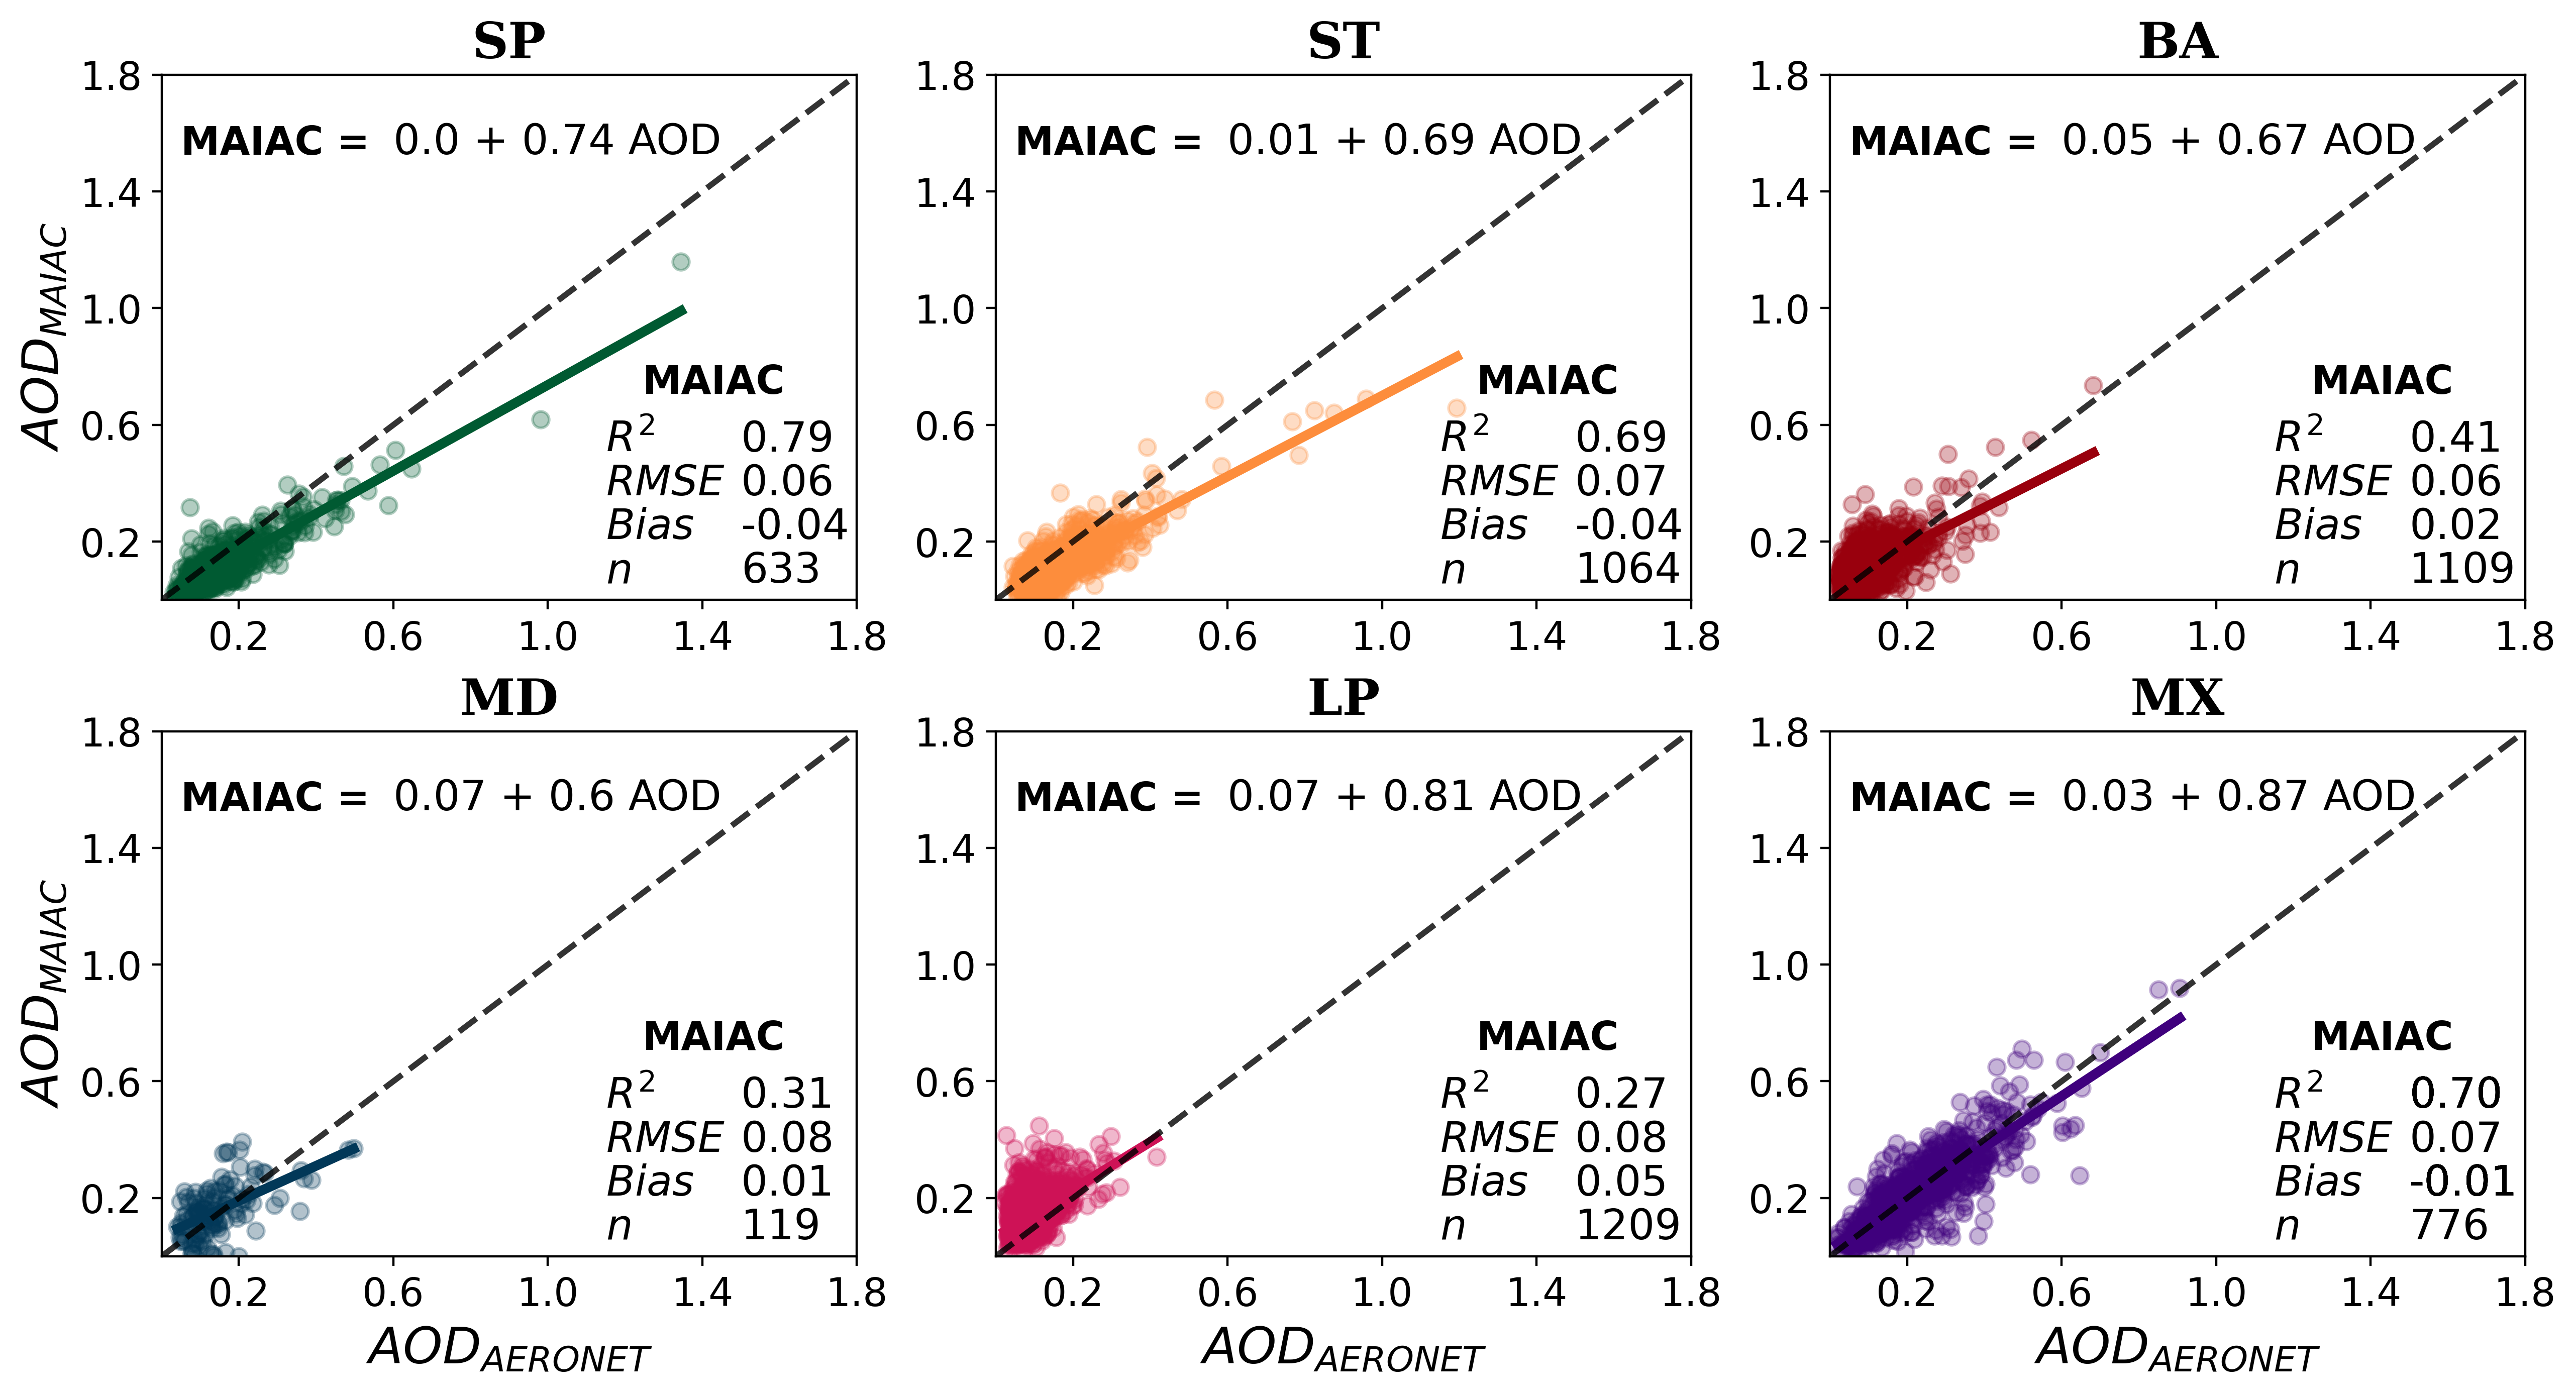

In [ ]:
# Regresion lineal MAIAC vs AERONET LATAM ventana 1km - 60 mins
color_maiac = ["#005a32","#fd8d3c","#99000d","#023858","#ce1256","#3f007d"] # CHILE "#fd8d3c"
resolucion_espaciotemporal = "1KM-60MIN-TOT"
dire = "D:/Josefina/paper_git/paper_maiac/datasets/V02/processed/merge_AER-MAIAC/Latam_C61/dia/1km/1km60min_copy"
# ante "D:/Josefina/paper_git/paper_maiac/datasets/V02/processed/Latam_C61/tot/1km/"
linear_regression_plot (resolucion_espaciotemporal = resolucion_espaciotemporal, path=dire,date_format='%d/%m/%Y',nrows=2,ncols=3,color_maiac =color_maiac ,plot='LALAL')

0
1
2
3
4
5


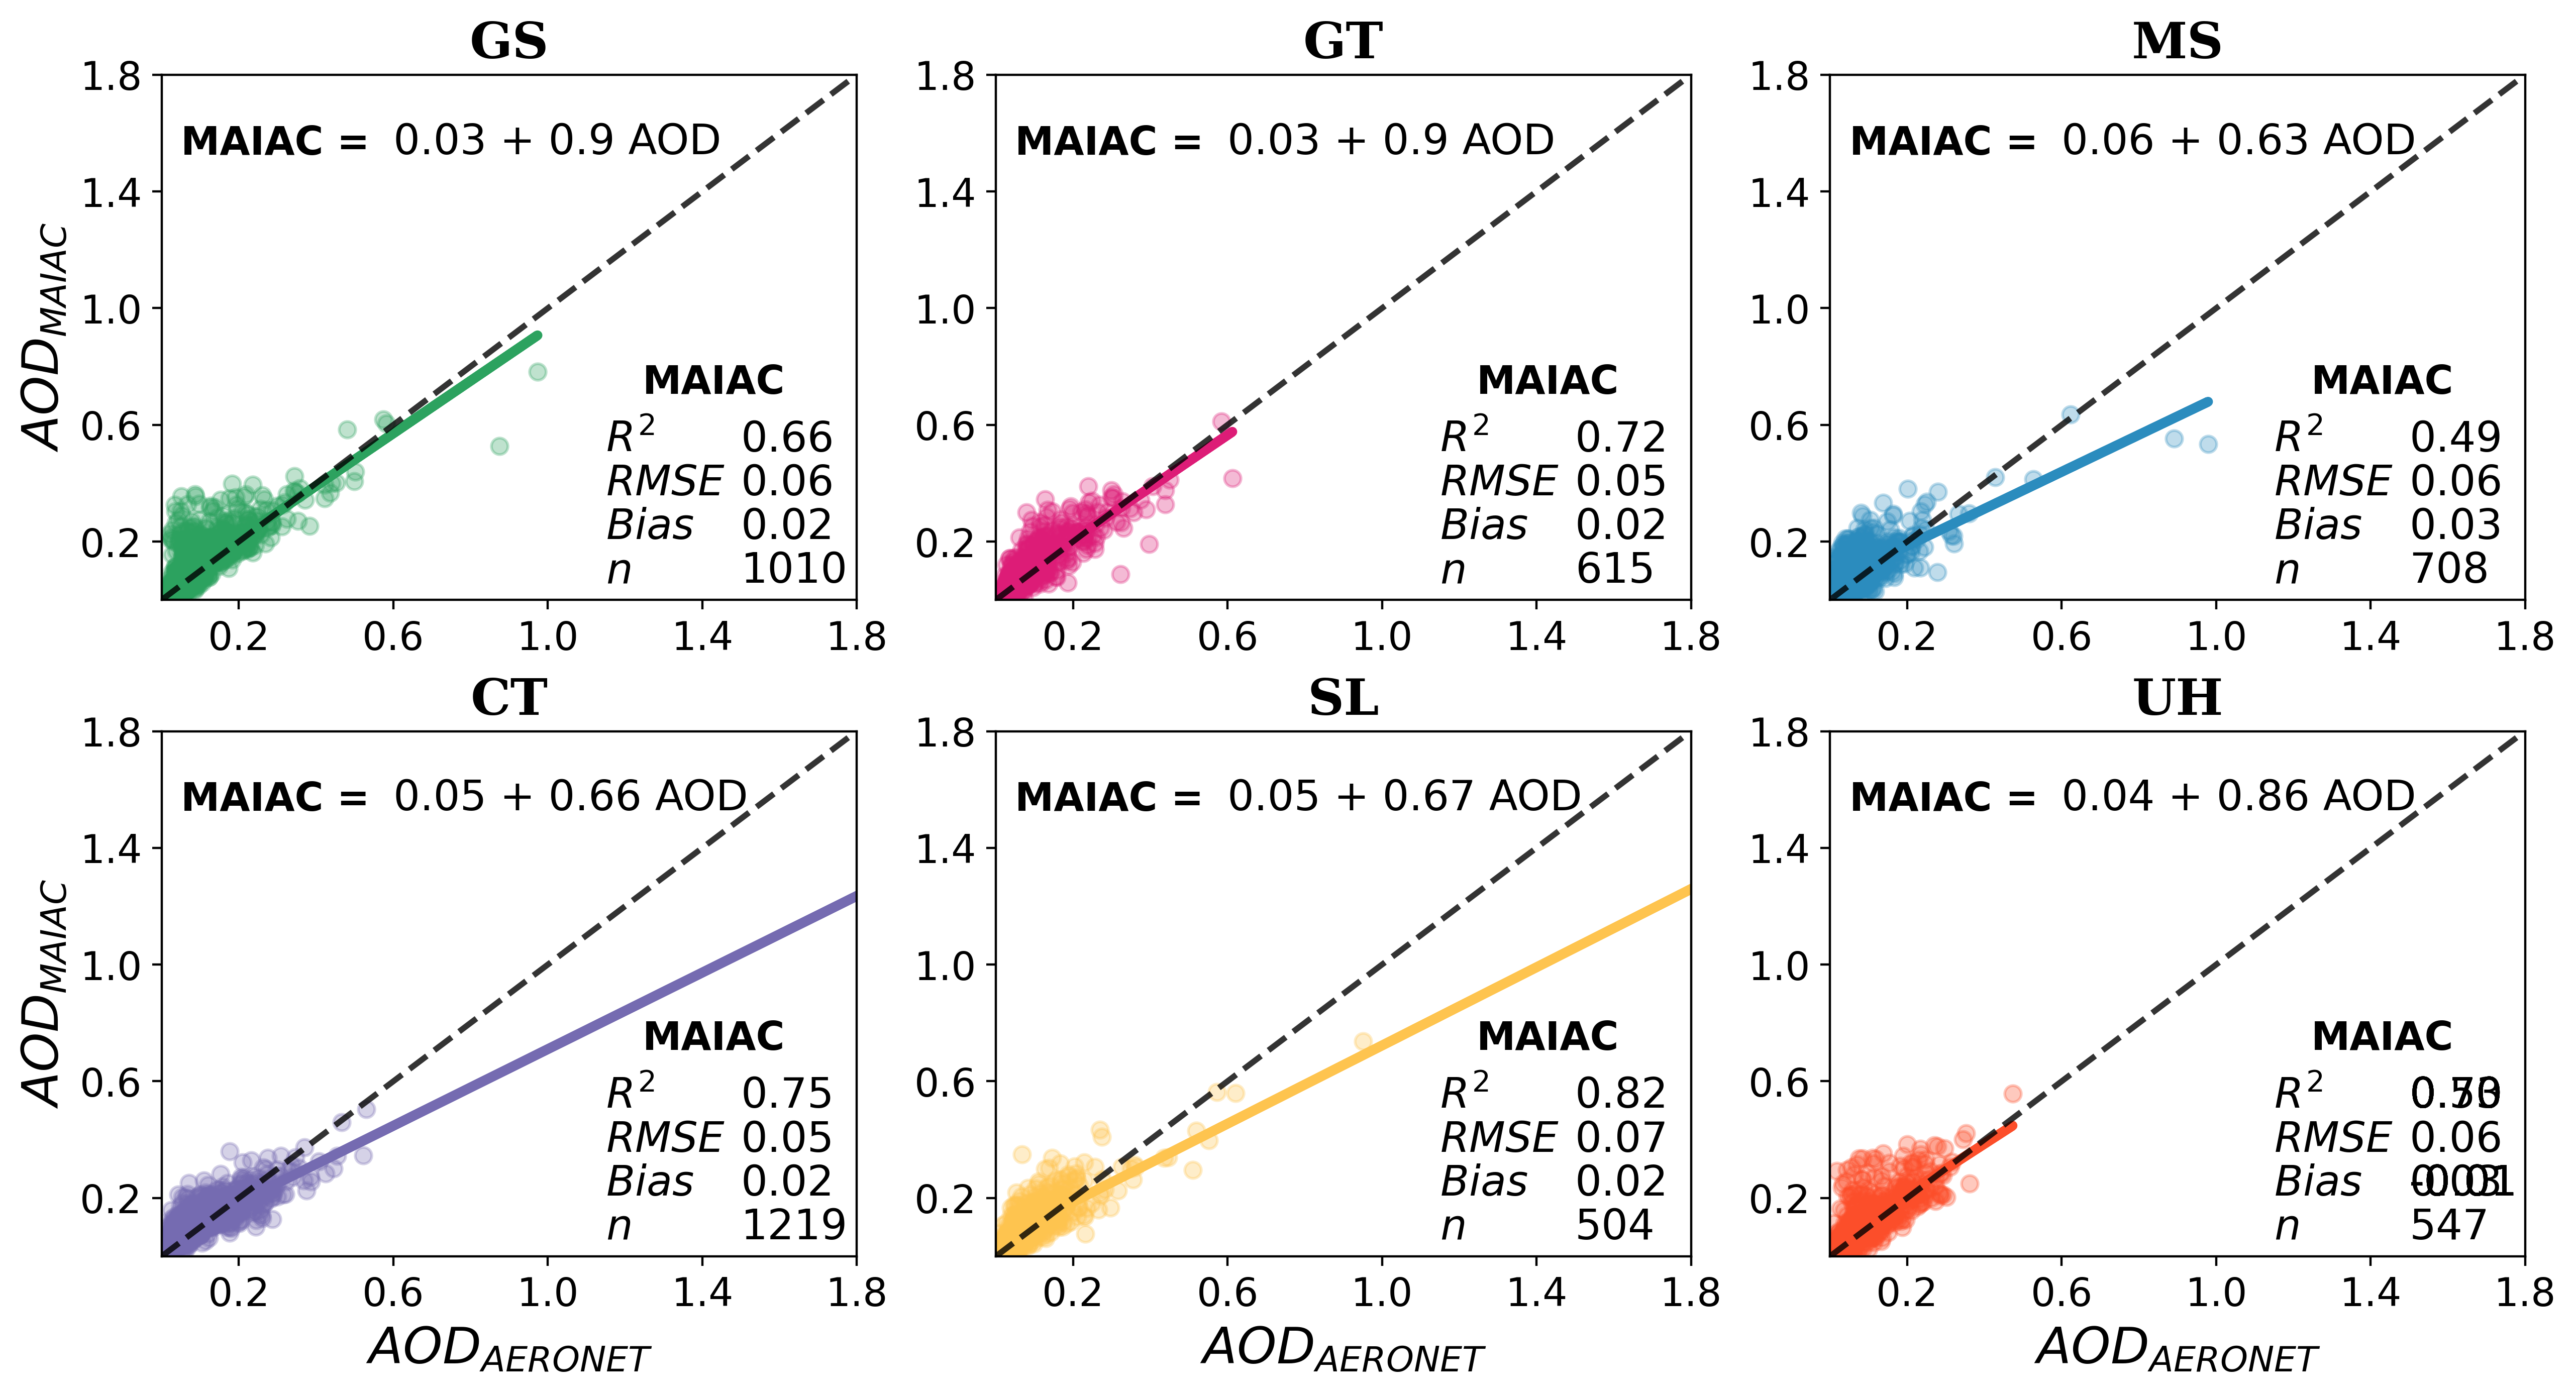

In [ ]:
# Regresion lineal MAIAC vs AERONET USA ventana 1km - 60 mins

color_maiac = ["#2ca25f","#dd1c77","#2b8cbe","#756bb1","#fec44f" ,"#fc4e2a"]

resolucion_espaciotemporal = "1KM-60MIN-TOT"
dire = "D:/Josefina/paper_git/paper_maiac/datasets/V02/processed/merge_BUFFER/USA_C61/horario/1km_v2/"
date = "%d/%m/%Y"
# ante "D:/Josefina/paper_git/paper_maiac/datasets/V02/processed/Latam_C61/tot/1km/"
linear_regression_plot (resolucion_espaciotemporal = resolucion_espaciotemporal, path=dire,date_format=date,nrows=2,ncols=3,color_maiac =color_maiac ,plot='LALAL')

FileNotFoundError: [WinError 3] El sistema no puede encontrar la ruta especificada: 'D:/Josefina/paper_git/paper_maiac/datasets/V02/processed/Latam_C61/dia/'

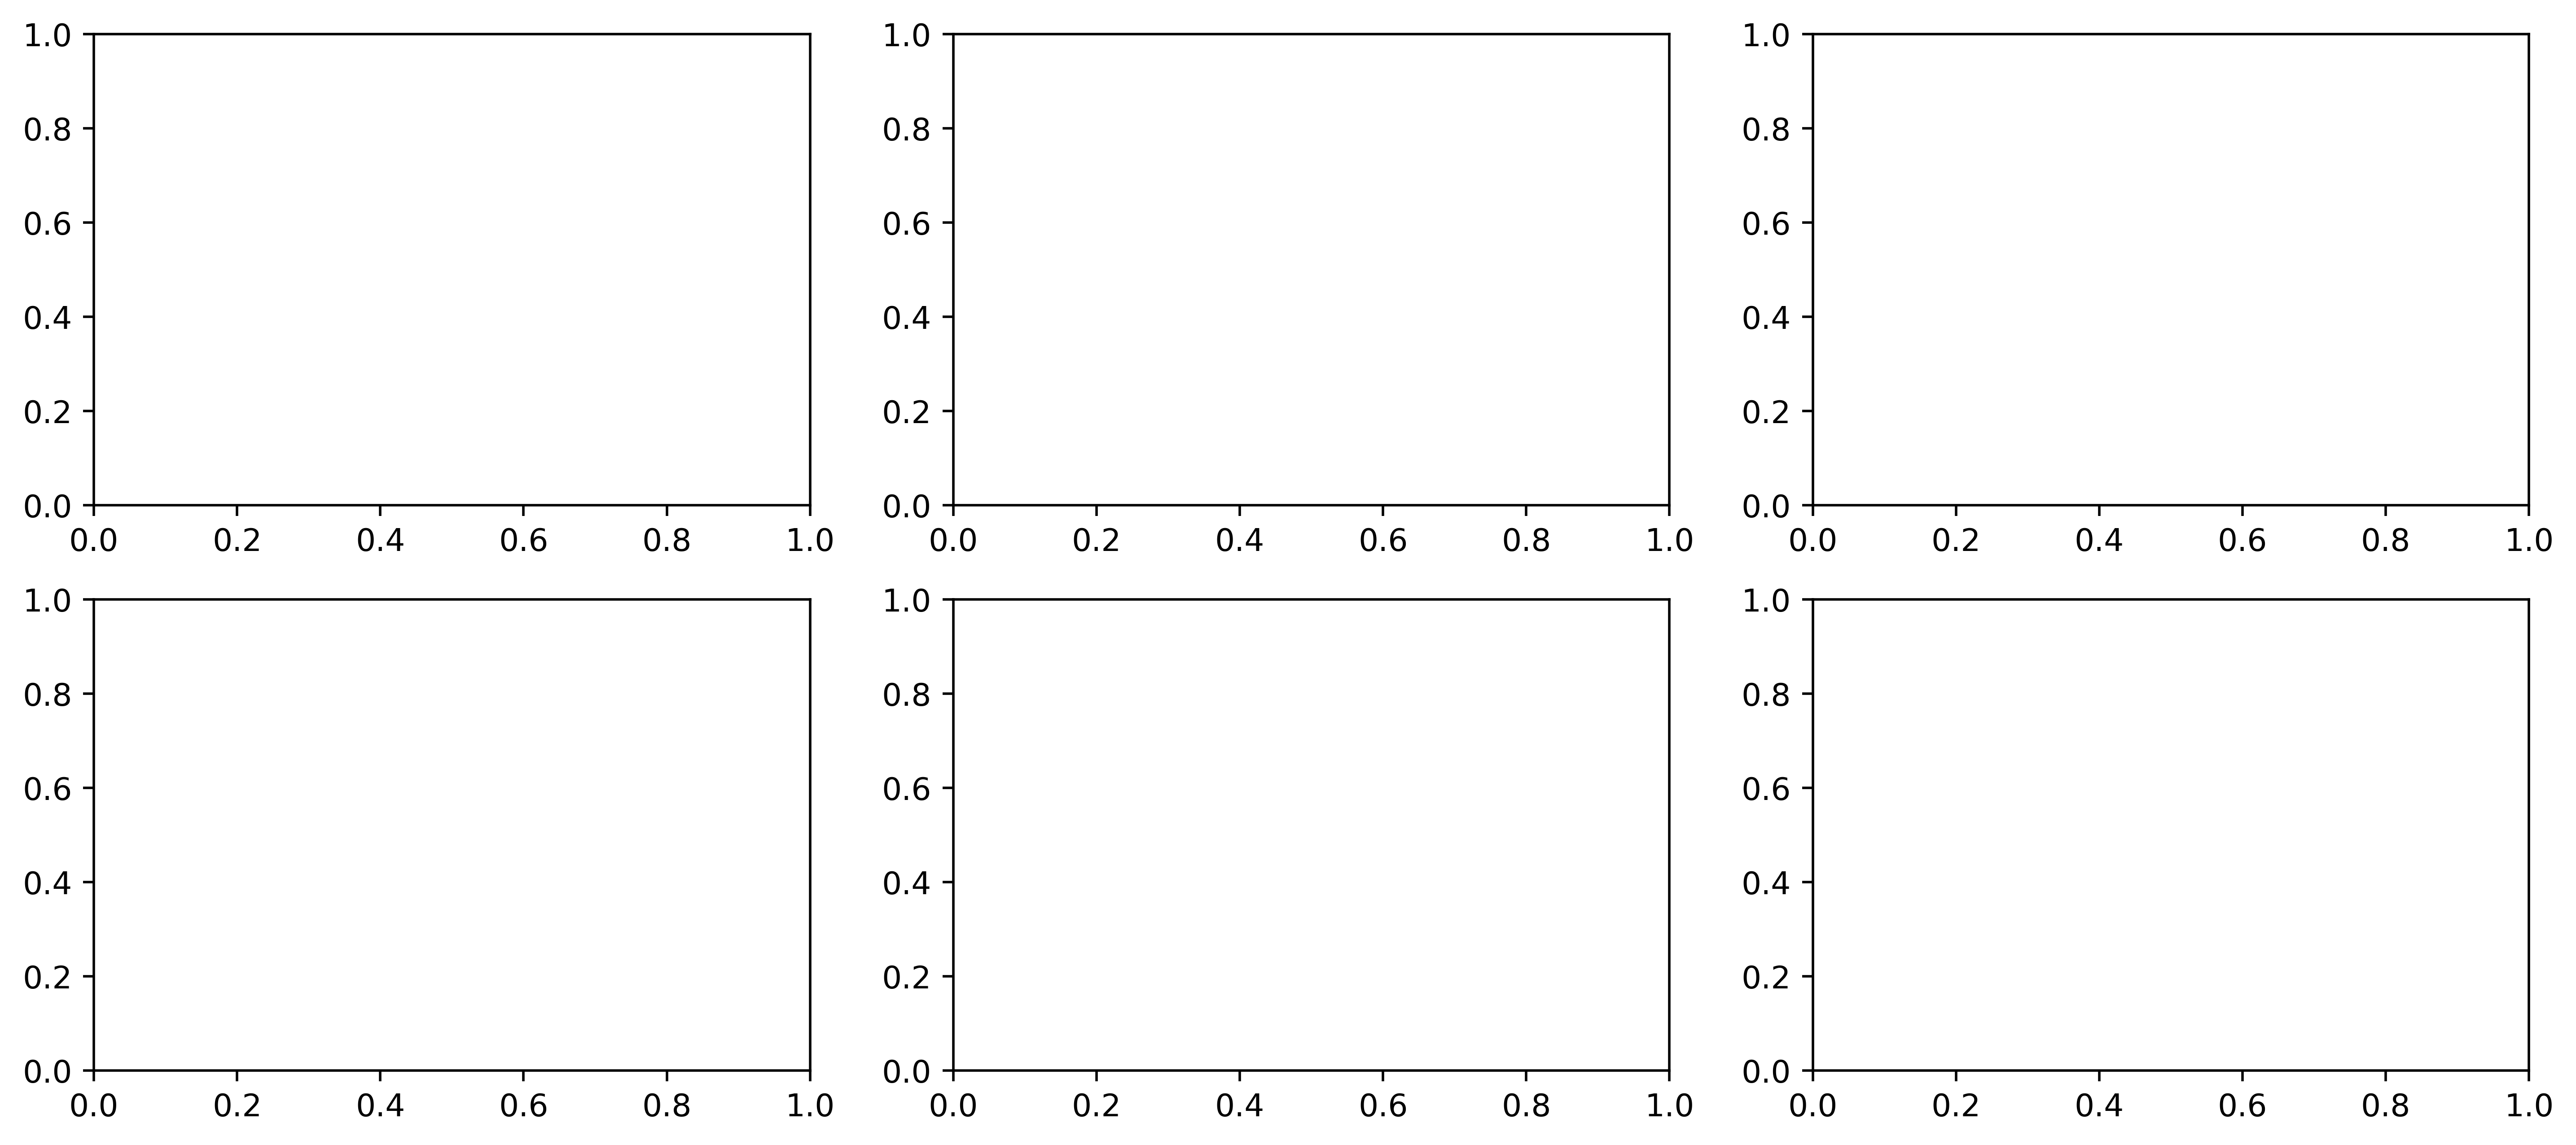

In [18]:
# DATOS PROMEDIOS DIARIOS 1km-C6.1
color_maiac = ["#005a32","#fd8d3c","#99000d","#023858","#ce1256","#3f007d"] # CHILE "#fd8d3c"
linear_regression_plot_mean_dia(path="D:/Josefina/paper_git/paper_maiac/datasets/V02/processed/Latam_C61/dia/",date_format='%Y-%m-%d',nrows=2,ncols=3,color_maiac =color_maiac ,plot='LALAL')

0
1
2
3
4
5


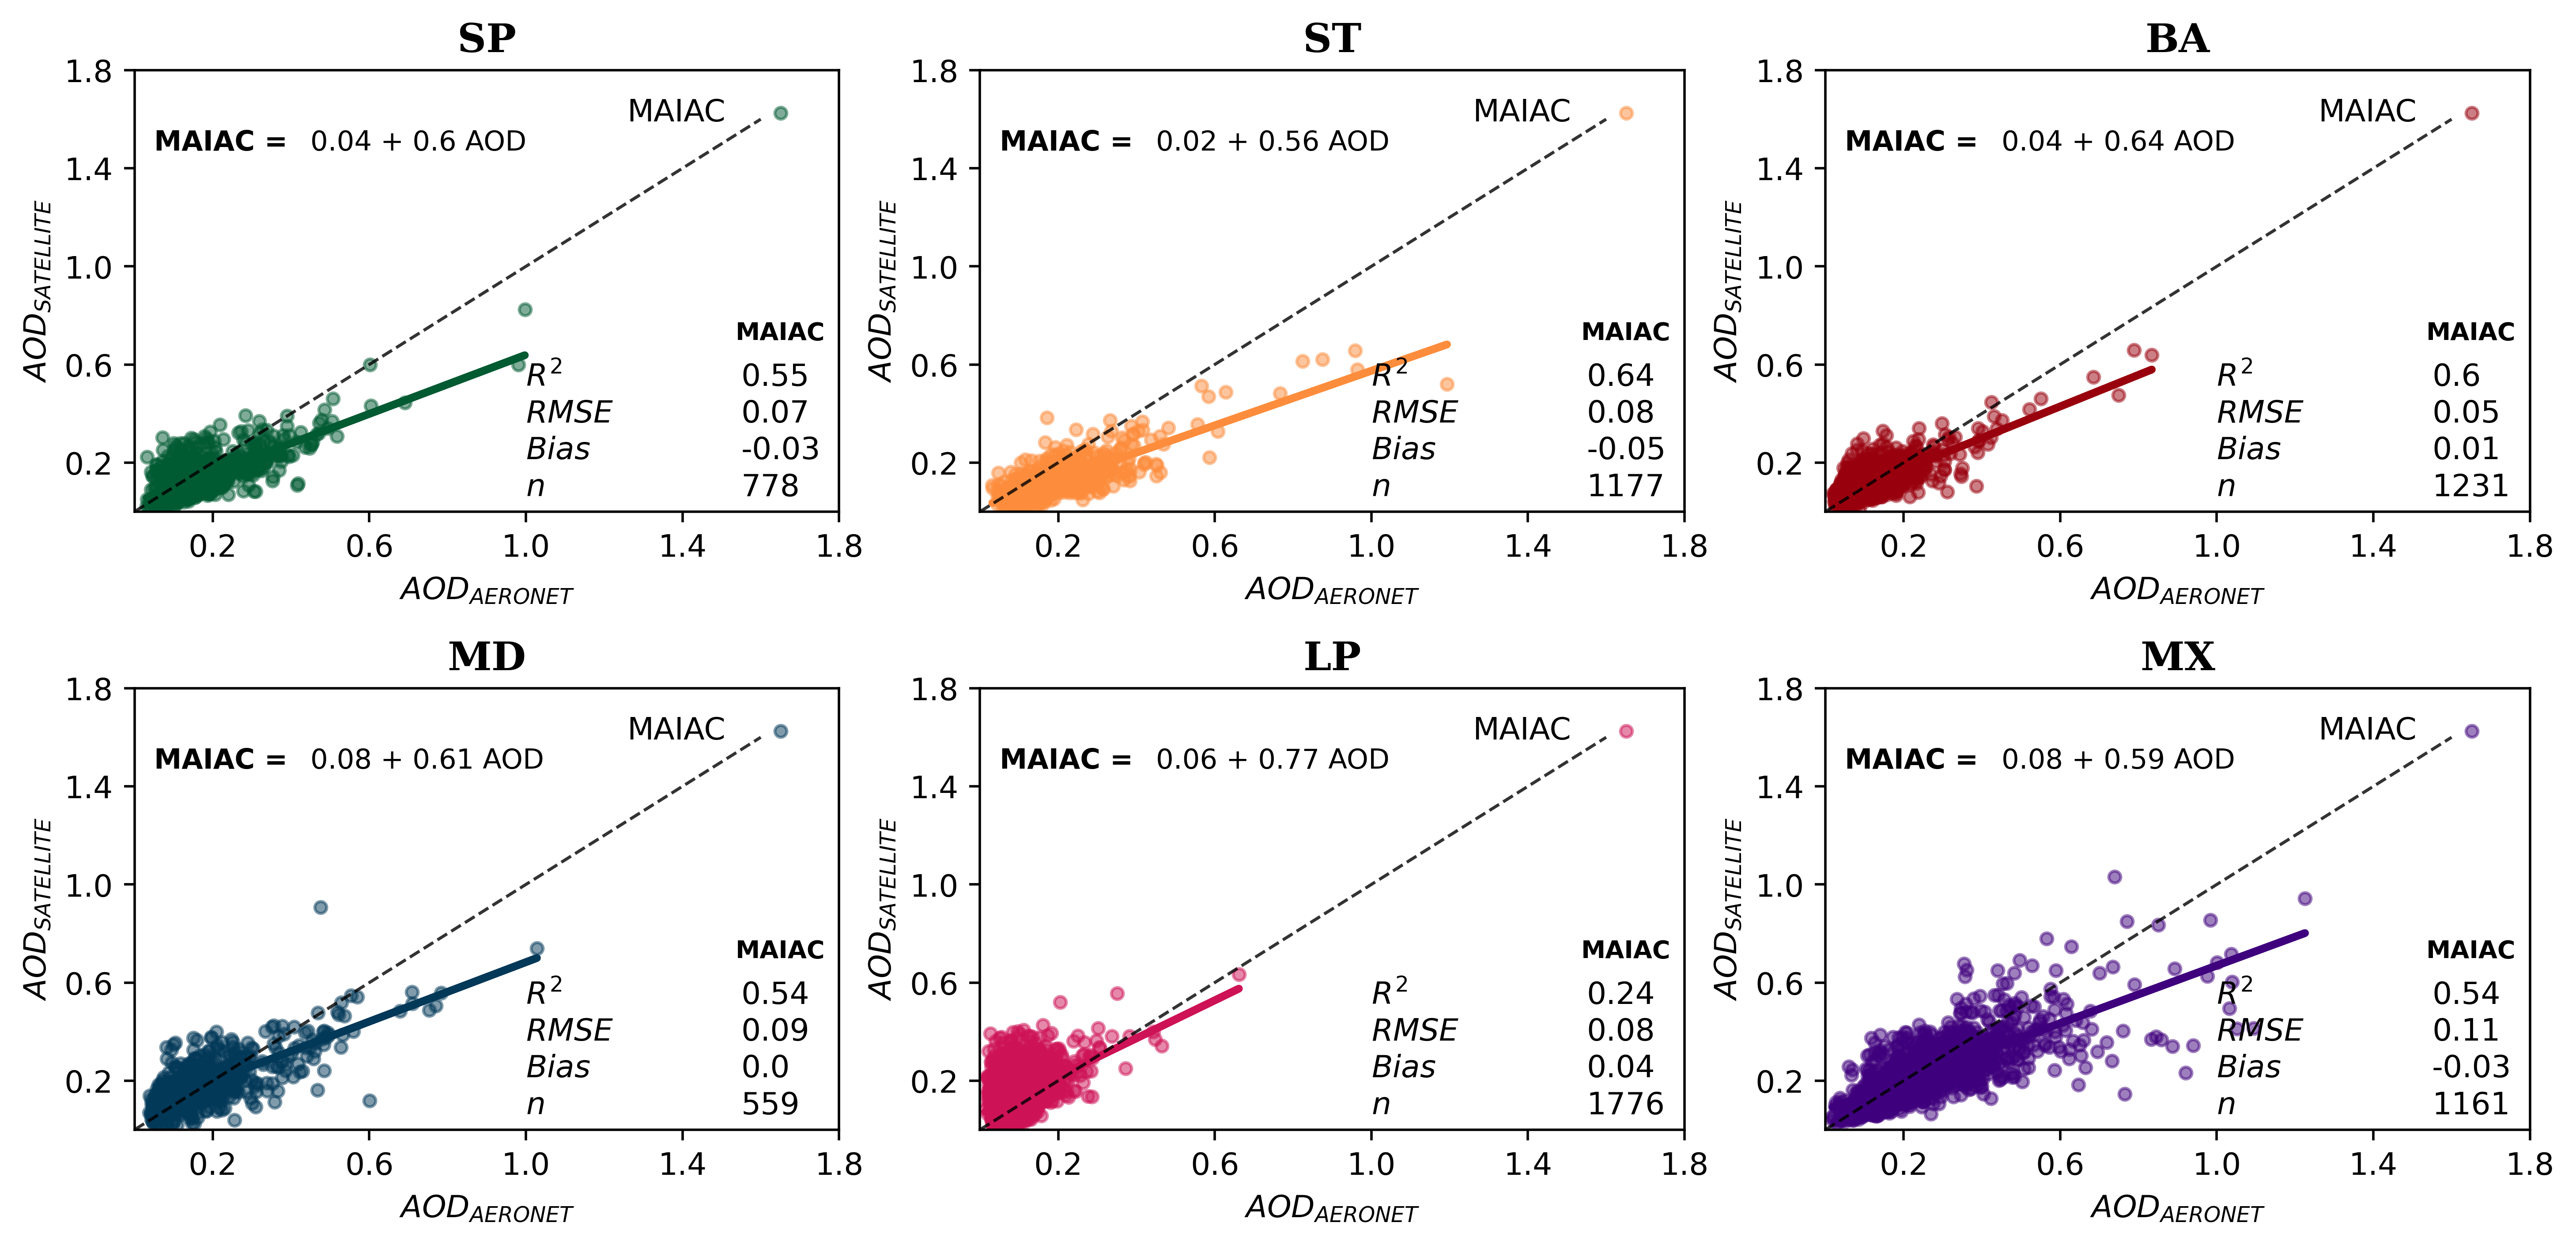

In [37]:
# DATOS PROMEDIOS DIARIOS 25 km-C6.1
color_maiac = ["#005a32","#fd8d3c","#99000d","#023858","#ce1256","#3f007d"] # CHILE "#fd8d3c"

direccion = "D:/Josefina/paper_git/paper_maiac/datasets/V01/processed/C6.1/dia/"
linear_regression_plot_mean_dia(path=direccion,date_format='%Y-%m-%d',nrows=2,ncols=3,color_maiac =color_maiac ,plot='LALAL')

#########################################################
# VERSION 2 ACTUALIZACION 02/2024

0
1
2
3
4
5


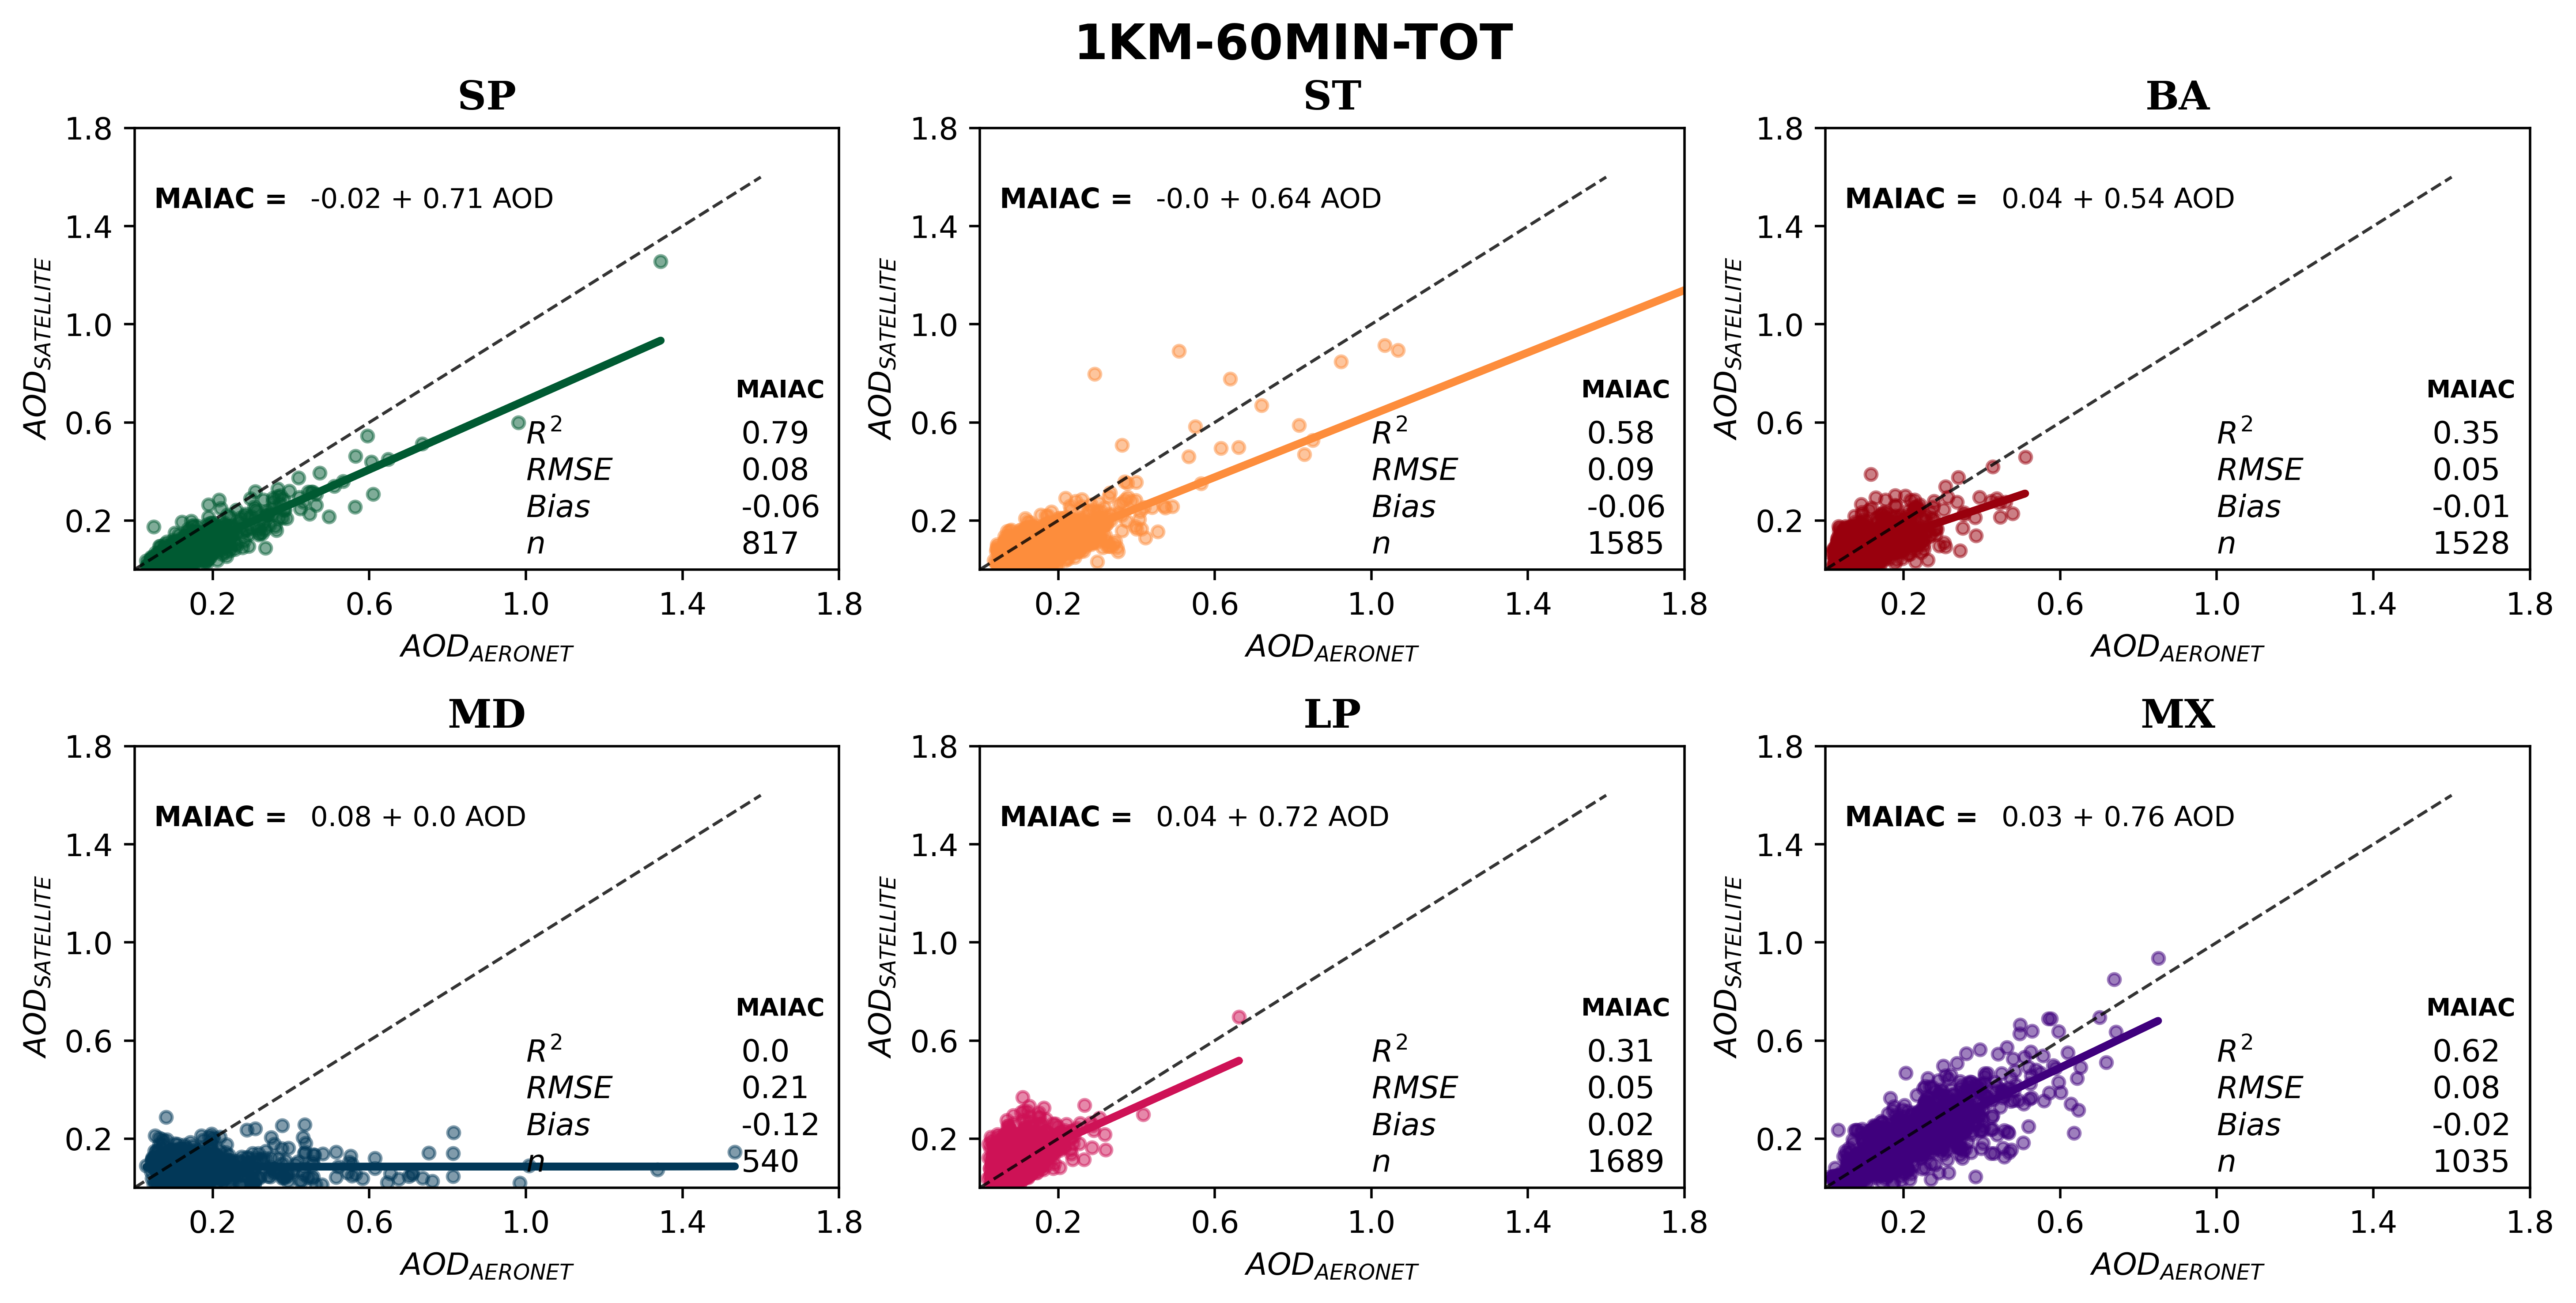

In [6]:
# TOTAL DATOS 1KM C6.1 VERSION 2 ACTUALIZACION 02/2024
color_maiac = ["#005a32","#fd8d3c","#99000d","#023858","#ce1256","#3f007d"] # CHILE "#fd8d3c"
resolucion_espaciotemporal = "1KM-60MIN-TOT"
linear_regression_plot (resolucion_espaciotemporal = resolucion_espaciotemporal, path="D:/Josefina/paper_git/paper_maiac/datasets/V02/processed/Latam_C60/tot/1km/60/",date_format='%Y-%m-%d',nrows=2,ncols=3,color_maiac =color_maiac ,plot='LALAL')

In [ ]:
def REU_list(DF, Pollutant, Units, Lambda = 1, u_xi = 0.0):
    '''
Esta función permite calcular la incertidumbre expandida relativa (REU).

Variables:
- DF: DataFrame que contiene los valores de AOD satelital (MAIAC y MODIS) y el AOD de referencia de AERONET.
- Pollutant: Nombre del contaminante de referencia, en este caso AERONET.
- Units: Nombres de las variables que se desean analizar; en nuestro caso, MAIAC y MODIS.
'''

    
    # NOTA: Sigma_err_x (Notacion NILU ) es la misma que u_xi (Notacion GDE2010 )
    Sigma_err_x = u_xi
    # Estas son listas que van a ir guardando diferentes resultados
    list_u = []
    list_reu = []
    list_bias = []
    list_noise = []
    list_reux = []
    list_biasx = []
    list_noisex = []
    list_verificacion = []
  
    # Las UNITS estan contempladas, es decir el contaminante. En este caso es MAIAC / MODIS
    for Unit in Units:
        x = DF[Pollutant] #AERONET
        y = DF[Unit] # Contaminante (AOD)
        
        # Control de NA
        mask = ~np.isnan(x) & ~np.isnan(y)
        x = x[mask]
        y = y[mask]
        n = len(x)
        
        #Pendiente e intercepto usando la regresion lineal
        slope, intercept, r, p, stderr = scipy.stats.linregress(x[mask], y[mask])
        b1 = slope
        b0 = intercept
        
        #Varianza del error de la ecuación para y = b0 + b1*x + v_i

        rss = (y - b0 - b1*x)**2
        RSS = rss.values.sum()
        Sigma_v_sqr = RSS/(n-2)
                
        #Varianza del error debido a la desvicion de la linea 1:1
        ec = (b0 + (b1 - 1)*x)**2
        ran = Sigma_v_sqr - Sigma_err_x**2
        
        #Resultados        
        U = ((ran + ec)**(1/2))
        
        REU = ((2*100)/y)*U
        
        bias = ((((2*100)/y)**2)*ec)**(1/2)
        
        noise = ((((2*100)/y)**2)*ran)**(1/2)
        
        verificacion = ((bias**2 + noise**2)**(1/2))
        verificacion_u = ((bias**2 + noise**2)**(1/2))/((2*100)/y)
        
        REUx = 2*U*100/x
        
        biasx = ((((2*100)/x)**2)*ec)**(1/2)
        
        noisex = ((((2*100)/x)**2)*ran)**(1/2)
        
        #Los resultados se van guardando en una lista separada generada anteriormente
        list_u.append(U)
        list_reu.append(REU)
        list_bias.append(bias)
        list_noise.append(noise)
        list_verificacion.append(verificacion)
        list_reux.append(REUx)
        list_biasx.append(biasx)
        list_noisex.append(noisex)
    
    # Concatenar las listas generadas
    U = pd.concat(list_u, axis=1)
    # Setear los nombres de las columnas
    Col_Names=[]
    for i in Units:
        i = 'U_'+ i
        Col_Names.append(i)
    U.columns = Col_Names
    U.rename_axis("Timestamp", axis='index', inplace=True)
    
    REU = pd.concat(list_reu, axis=1)
    Col_Names=[]
    for i in Units:
        i = 'REU_'+ i
        Col_Names.append(i)
    REU.columns = Col_Names
    REU.rename_axis("Timestamp", axis='index', inplace=True)
    
    bias = pd.concat(list_bias, axis=1)
    Col_Names=[]
    for i in Units:
        i = 'b_'+ i
        Col_Names.append(i)
    bias.columns = Col_Names
    bias.rename_axis("Timestamp", axis='index', inplace=True)
    
    noise = pd.concat(list_noise, axis=1)
    Col_Names=[]
    for i in Units:
        i = 'n_'+ i
        Col_Names.append(i)
    noise.columns = Col_Names
    noise.rename_axis("Timestamp", axis='index', inplace=True)
    
    verificacion = pd.concat(list_verificacion, axis =1 )
    Col_Names=[]
    for i in Units:
        i = 'verificacion_'+ i
        Col_Names.append(i)
    verificacion.columns = Col_Names
    verificacion.rename_axis("Timestamp", axis='index', inplace=True)
    
    REUx = pd.concat(list_reux, axis=1)
    Col_Names=[]
    for i in Units:
        i = 'REUx_'+ i
        Col_Names.append(i)
    REUx.columns = Col_Names
    REUx.rename_axis("Timestamp", axis='index', inplace=True)
    
    biasx = pd.concat(list_biasx, axis=1)
    Col_Names=[]
    for i in Units:
        i = 'bx_'+ i
        Col_Names.append(i)
    biasx.columns = Col_Names
    biasx.rename_axis("Timestamp", axis='index', inplace=True)
    
    noisex = pd.concat(list_noisex, axis=1)
    Col_Names=[]
    for i in Units:
        i = 'nx_'+ i
        Col_Names.append(i)
    noisex.columns = Col_Names
    noisex.rename_axis("Timestamp", axis='index', inplace=True)
    
   
    REUyx = pd.concat((DF[Pollutant], U, REU, bias, noise, REUx, biasx, noisex,verificacion), axis=1)#, 

    
    return REUyx

In [23]:
# La funcion anterior calculaba la REU, y con esta se hace el plot
def REU_plot(path, date_format,nrows,ncols,color_maiac,plot,resolucion_espaciotemporal):
    '''
Esta función permite graficar la REU previamente calculada.
Los datos de cada estación de interés se encuentran en una carpeta en formato .csv previamente procesados.
La función recorre la carpeta y toma cada uno de estos archivos para luego generar el gráfico correspondiente.

Variables:
- path: ruta a la carpeta donde se encuentran los archivos en formato .csv.
- date_format: formato de la columna de fecha del archivo de interés.
  Por ejemplo: date_format='%Y-%m-%d %H:%M:%S'
- nrows: número de filas que tendrá la grilla de gráficos.
- ncols: número de columnas que tendrá la grilla de gráficos.
- Paleta de colores para cada estación MAIAC-MODIS. Por ejemplo:
  color_modis = ["#74c476","#fed976","#fb6a4a", "#74a9cf","#df65b0","#807dba"]
  color_maiac = ["#005a32","#fd8d3c","#99000d","#023858","#ce1256","#3f007d"]
'''

    i=0 
    j=0 
    edge_color_maiac = ["#004529", "#feb24c","#67000d","#081d58","#67001f","#4d004b"]
    edge_color_modis = ["#41ab5d","#feb24c","#cb181d","#045a8d","#ce1256","#810f7c"]
    

    fig, ax = plt.subplots(ncols=ncols,nrows=nrows,  figsize=(14,6),dpi=500)
    fig.suptitle(resolucion_espaciotemporal, fontsize=16, fontweight='bold')

    #Recorrer archivos que estan en la carpeta
    for p,files in enumerate(os.listdir(path)):
        N = len(os.listdir(path))
        data = pd.read_csv(os.path.join(path,files))
        #Crear columna con la fecha llamada "Timestamp".
        #data["Timestamp"] = data["Date_MODIS"].apply(lambda x: datetime.strptime(x,date_format))
        data["Timestamp"] = data["date"].apply(lambda x: datetime.strptime(x,date_format))
        #Se convierte en index la columna
        data.set_index('Timestamp', inplace = True)
        data_mean_period_len =len(data.dropna(how='all'))
        # Llamar a la funcion anterior que calcula la reu

        # Ver bien cuales son las variables segun el archivo usado
        df_REUxy = REU_list(DF = data, Pollutant = 'AOD_550_AER_mean', 
        Units = ["AOD_550_maiac_mean"], 
        #Units = ["AOD_550_maiac"], 
        Lambda = 1, u_xi = 0.0)
        # Nombre de la estacion
        station_name = files [2:4]
        ########################                VARIABLES                ########################
        
        # Revisar los nombres de las variables
        x = df_REUxy["AOD_550_AER_mean"]
        #y_maiac = df_REUxy["REUx_AOD_550_maiac"]
        y_maiac = df_REUxy["REUx_AOD_550_maiac_mean"]
        n = len(x)
        min_maiac = round(min(df_REUxy["REUx_AOD_550_maiac_mean"]),2)
        max_maiac = round(max(df_REUxy["REUx_AOD_550_maiac_mean"]),2)

        ########################                PLOT                ########################
        ## Si es Latam o si es USA
        sp_media = 0.18
        st_media = 0.16
        ba_media = 0.11
        md_media = 0.2
        lp_media = 0.08
        mx_media = 0.29

        # gs_media = 0.12
        # gt_media = 0.13
        # ms_media = 0.13
        # ct_media = 0.11
        # sl_media = 0.13
        # uh_media = 0.14
        
        # Figure
        #Scatter plot REU vs Ref
        ax[i][j].scatter(x, y_maiac, s=10, color=color_maiac[p], alpha=0.5, linewidth=1) # Color
        ax[i][j].grid(color = 'grey', linestyle = '--', linewidth = 0.2)

       # Se agrega la linea con valores maximos y minimos de MAIAC/MODIS
        ax[i][j].hlines(y=min_maiac , xmin=0, xmax=1.2, color='black', linewidth=1, alpha=0.8, linestyle = '--')
        
        ##### ---- LATAM ---- #####
        ax[0][0].vlines(x= sp_media, ymin=0, ymax=300, color=color_maiac[0], linewidth=1, alpha=0.8, linestyle = '-')
        ax[0][1].vlines(x= st_media, ymin=0, ymax=300, color=color_maiac[1], linewidth=1, alpha=0.8, linestyle = '-')
        ax[0][2].vlines(x= ba_media, ymin=0, ymax=300, color=color_maiac[2], linewidth=1, alpha=0.8, linestyle = '-')
        ax[1][0].vlines(x= md_media, ymin=0, ymax=300, color=color_maiac[3], linewidth=1, alpha=0.8, linestyle = '-')
        ax[1][1].vlines(x= lp_media, ymin=0, ymax=300, color=color_maiac[4], linewidth=1, alpha=0.8, linestyle = '-')
        ax[1][2].vlines(x= mx_media, ymin=0, ymax=300, color=color_maiac[5], linewidth=1, alpha=0.8, linestyle = '-')
        ax[0][0].text(sp_media-0.05, 150, "AER mean", rotation=90, va='center',size=9)
        ax[0][1].text(st_media-0.05, 150, "AER mean", rotation=90, va='center',size=9)
        ax[0][2].text(ba_media-0.05, 150, "AER mean", rotation=90, va='center',size=9)
        ax[1][0].text(md_media-0.05, 150, "AER mean", rotation=90, va='center',size=9)
        ax[1][1].text(lp_media-0.05, 150, "AER mean", rotation=90, va='center',size=9)
        ax[1][2].text(mx_media-0.05, 150, "AER mean", rotation=90, va='center',size=9)
    
        ##### ---- USA ---- #####
        # ax[0][0].vlines(x= gs_media, ymin=0, ymax=300, color=color_maiac[0], linewidth=1, alpha=0.8, linestyle = '-')
        # ax[0][1].vlines(x= gt_media, ymin=0, ymax=300, color=color_maiac[1], linewidth=1, alpha=0.8, linestyle = '-')
        # ax[0][2].vlines(x= ms_media, ymin=0, ymax=300, color=color_maiac[2], linewidth=1, alpha=0.8, linestyle = '-')
        # ax[1][0].vlines(x= ct_media, ymin=0, ymax=300, color=color_maiac[3], linewidth=1, alpha=0.8, linestyle = '-')
        # ax[1][1].vlines(x= sl_media, ymin=0, ymax=300, color=color_maiac[4], linewidth=1, alpha=0.8, linestyle = '-')
        # ax[1][2].vlines(x= uh_media, ymin=0, ymax=300, color=color_maiac[5], linewidth=1, alpha=0.8, linestyle = '-')
        # ax[0][0].text(gs_media-0.05, 150, "AER mean", rotation=90, va='center',size=9)
        # ax[0][1].text(gt_media-0.05, 150, "AER mean", rotation=90, va='center',size=9)
        # ax[0][2].text(ms_media-0.05, 150, "AER mean", rotation=90, va='center',size=9)
        # ax[1][0].text(ct_media-0.05, 150, "AER mean", rotation=90, va='center',size=9)
        # ax[1][1].text(sl_media-0.05, 150, "AER mean", rotation=90, va='center',size=9)
        # ax[1][2].text(uh_media-0.05, 150, "AER mean", rotation=90, va='center',size=9)
        
        # Mostrar texto
        ax[i][j].text(0.8, min_maiac+5,(f'$REU = {min_maiac}$'),
                      ha="left", va="center",fontdict={'family': 'serif', 
                     'color' : 'Black',
                     'weight': 'bold',
                     'size': 9})

        # Titulo de los subplots
        ax[i][j].set_title(station_name,fontsize=13,fontdict={'family': 'serif', 
            'color' : 'Black',
            'weight': 'bold',
            'size': 16})
        # Limite del eje X
        ax[i][j].set_xlim(0,1.2) 
        # Limite del eje Y
        ax[i][j].set_ylim(0,300)
        
#         ax[i][j].set_yticks(range(0, 301, 20))
        # Nombre de los ejes
        ax[i][j].set_xlabel(r'$AOD_{AERONET}$',size=10)
        ax[i][j].set_ylabel(r'REU $AOD_{Satellite}$',size=10)
        # Configuracion de los subplots
        plt.subplots_adjust(left=0.125,bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)
        # Titulo de la legenda
        tittle_legend = ["MAIAC"]
        ax[i][j].legend(frameon = False, markerfirst = False, fontsize = 10)
        # Location of data in each subplot
        if j == ncols-1:
            i = i+1
            j = 0
        else:
            j = j+1
    
       # Guardar
    if plot == 'save':
        return(plt.savefig("REU_plot.jpg", dpi=500))
    else:
        return(plt.show())

C:\Users\Josefina Urquiza\AppData\Local\Temp\ipykernel_6600\4185227386.py:138: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i][j].legend(frameon = False, markerfirst = False, fontsize = 10)
C:\Users\Josefina Urquiza\AppData\Local\Temp\ipykernel_6600\4185227386.py:138: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i][j].legend(frameon = False, markerfirst = False, fontsize = 10)
C:\Users\Josefina Urquiza\AppData\Local\Temp\ipykernel_6600\4185227386.py:138: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i][j].legend(frameon = False, markerfirst = False, fontsize = 10)
C:\Users\Josefina Urquiza\AppData\Local\

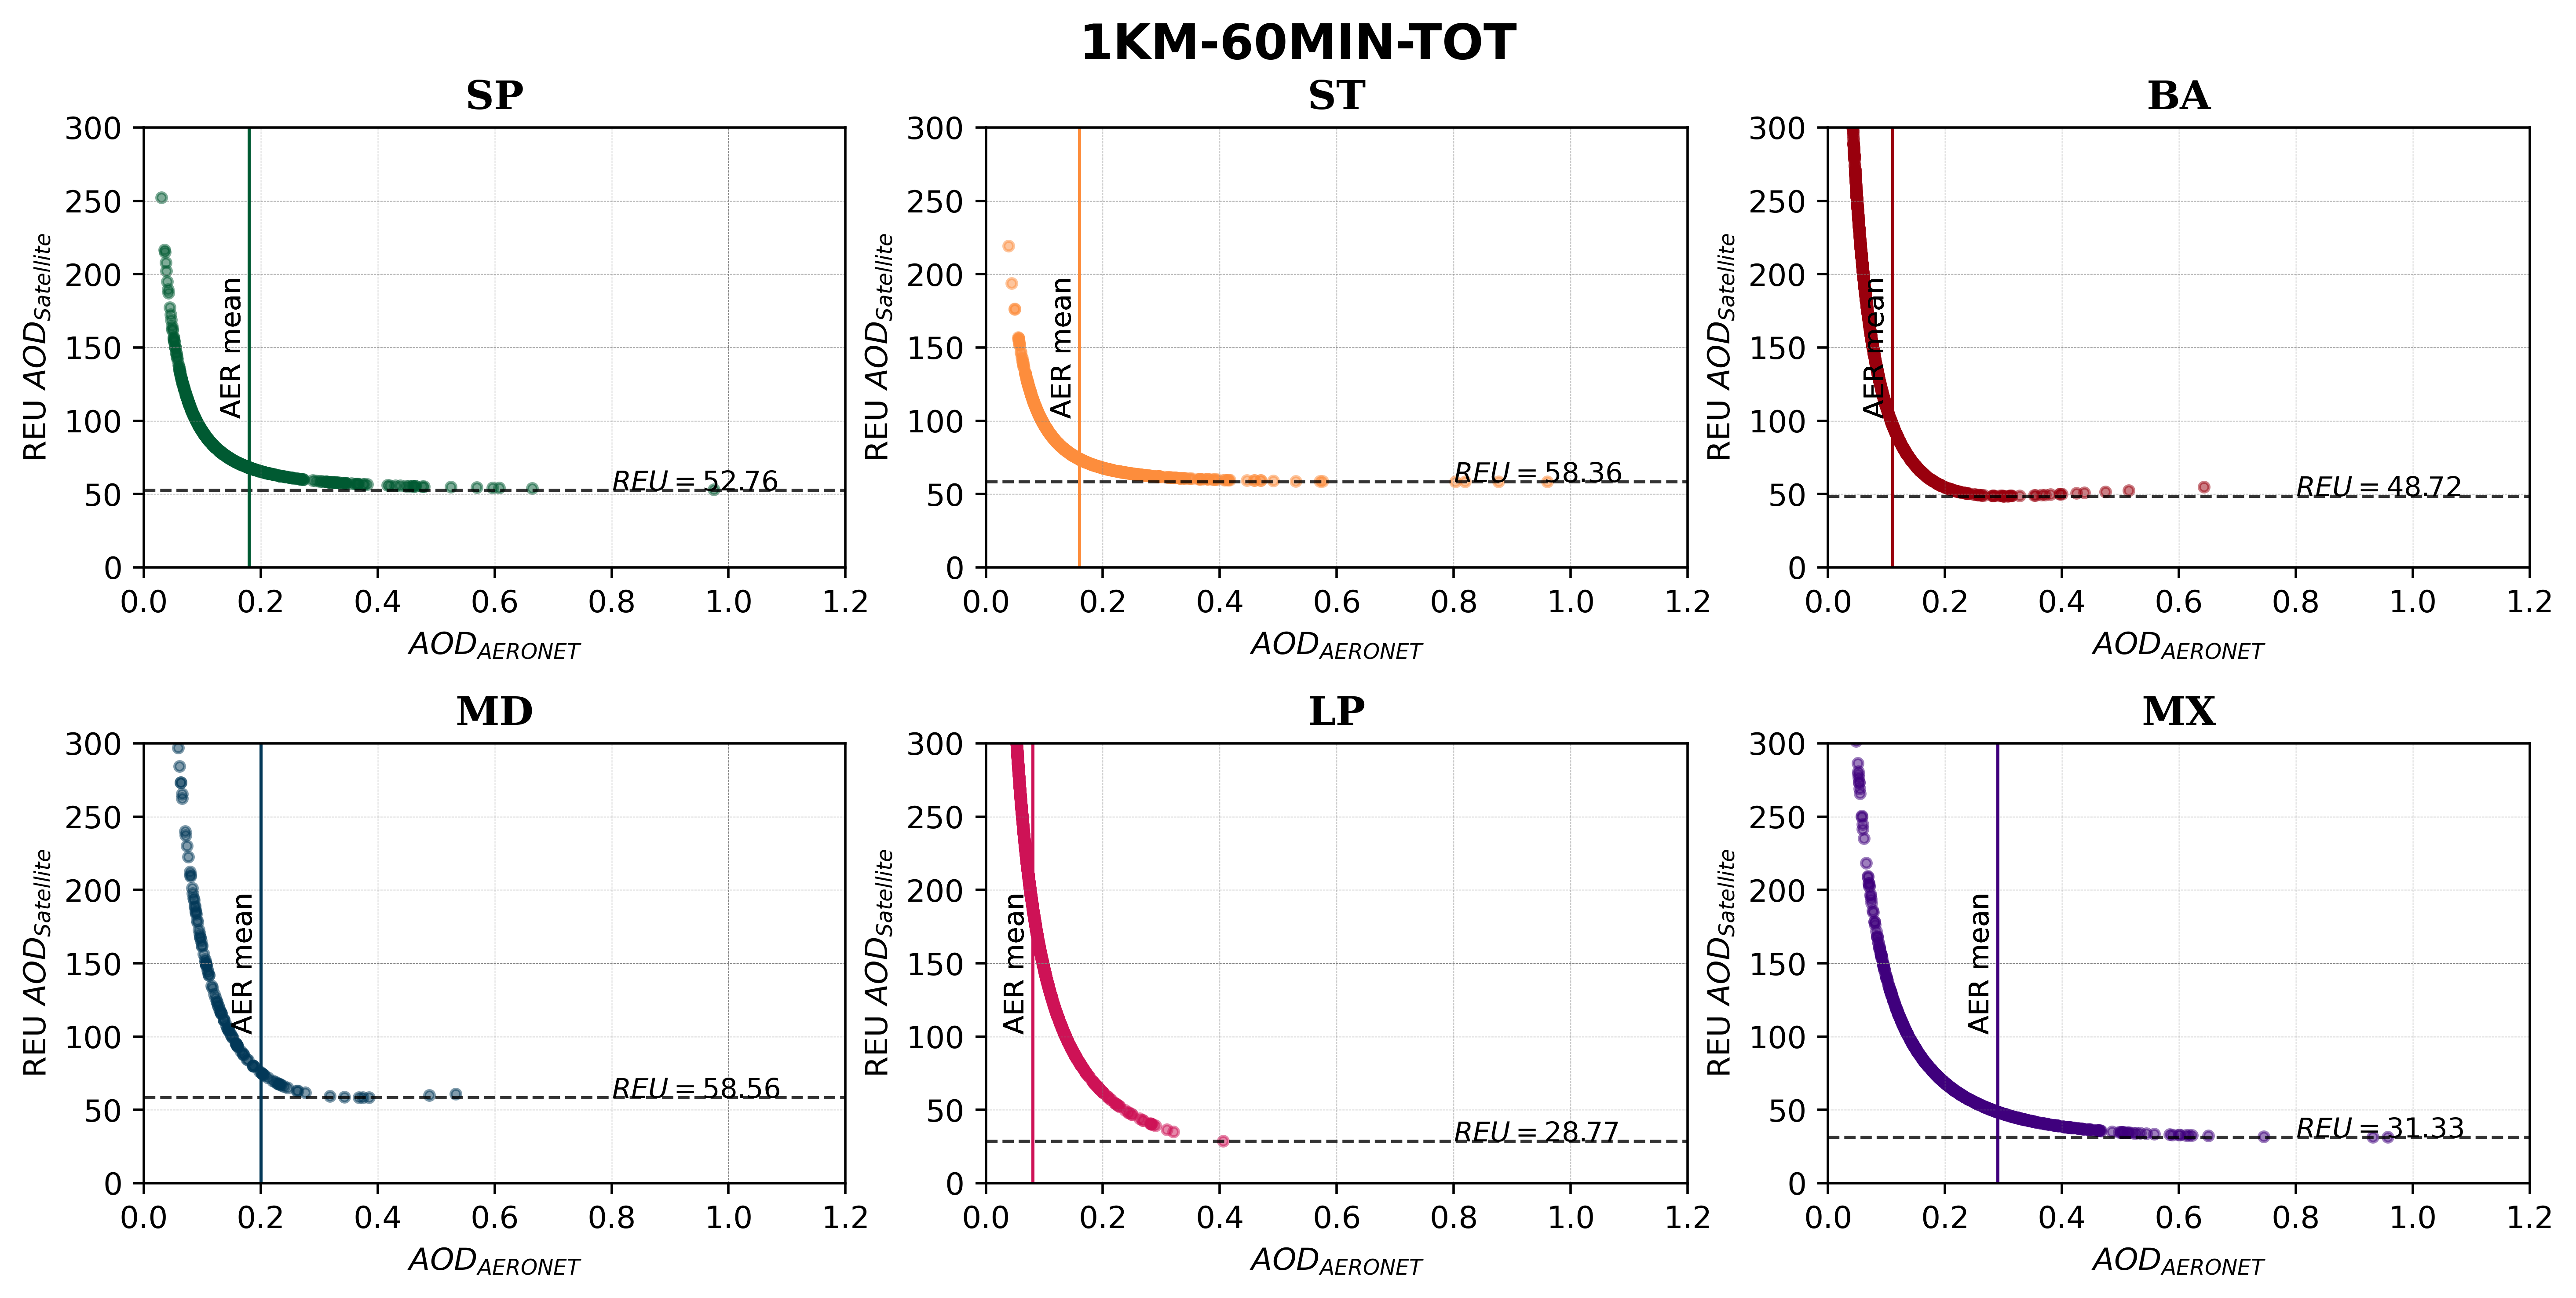

In [ ]:
# Plot de la REU en Latam

#dir ="D:/Josefina/paper_git/paper_maiac/datasets/V02/processed/Latam_C61/tot/"
dir = "D:/Josefina/paper_git/paper_maiac/datasets/V02/processed/merge_AER-MAIAC/Latam_C61/dia/1km/1km30min_copy"
resolucion_espaciotemporal = "1KM-60MIN-TOT"
REU_plot(path=dir,date_format='%Y-%m-%d',nrows=2,ncols=3,color_maiac = ["#005a32","#fd8d3c","#99000d","#023858","#ce1256","#3f007d"],plot = 'LALAL',resolucion_espaciotemporal=resolucion_espaciotemporal)


C:\Users\Josefina Urquiza\AppData\Local\Temp\ipykernel_6600\4185227386.py:138: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i][j].legend(frameon = False, markerfirst = False, fontsize = 10)
C:\Users\Josefina Urquiza\AppData\Local\Temp\ipykernel_6600\4185227386.py:138: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i][j].legend(frameon = False, markerfirst = False, fontsize = 10)
C:\Users\Josefina Urquiza\AppData\Local\Temp\ipykernel_6600\4185227386.py:138: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i][j].legend(frameon = False, markerfirst = False, fontsize = 10)
C:\Users\Josefina Urquiza\AppData\Local\

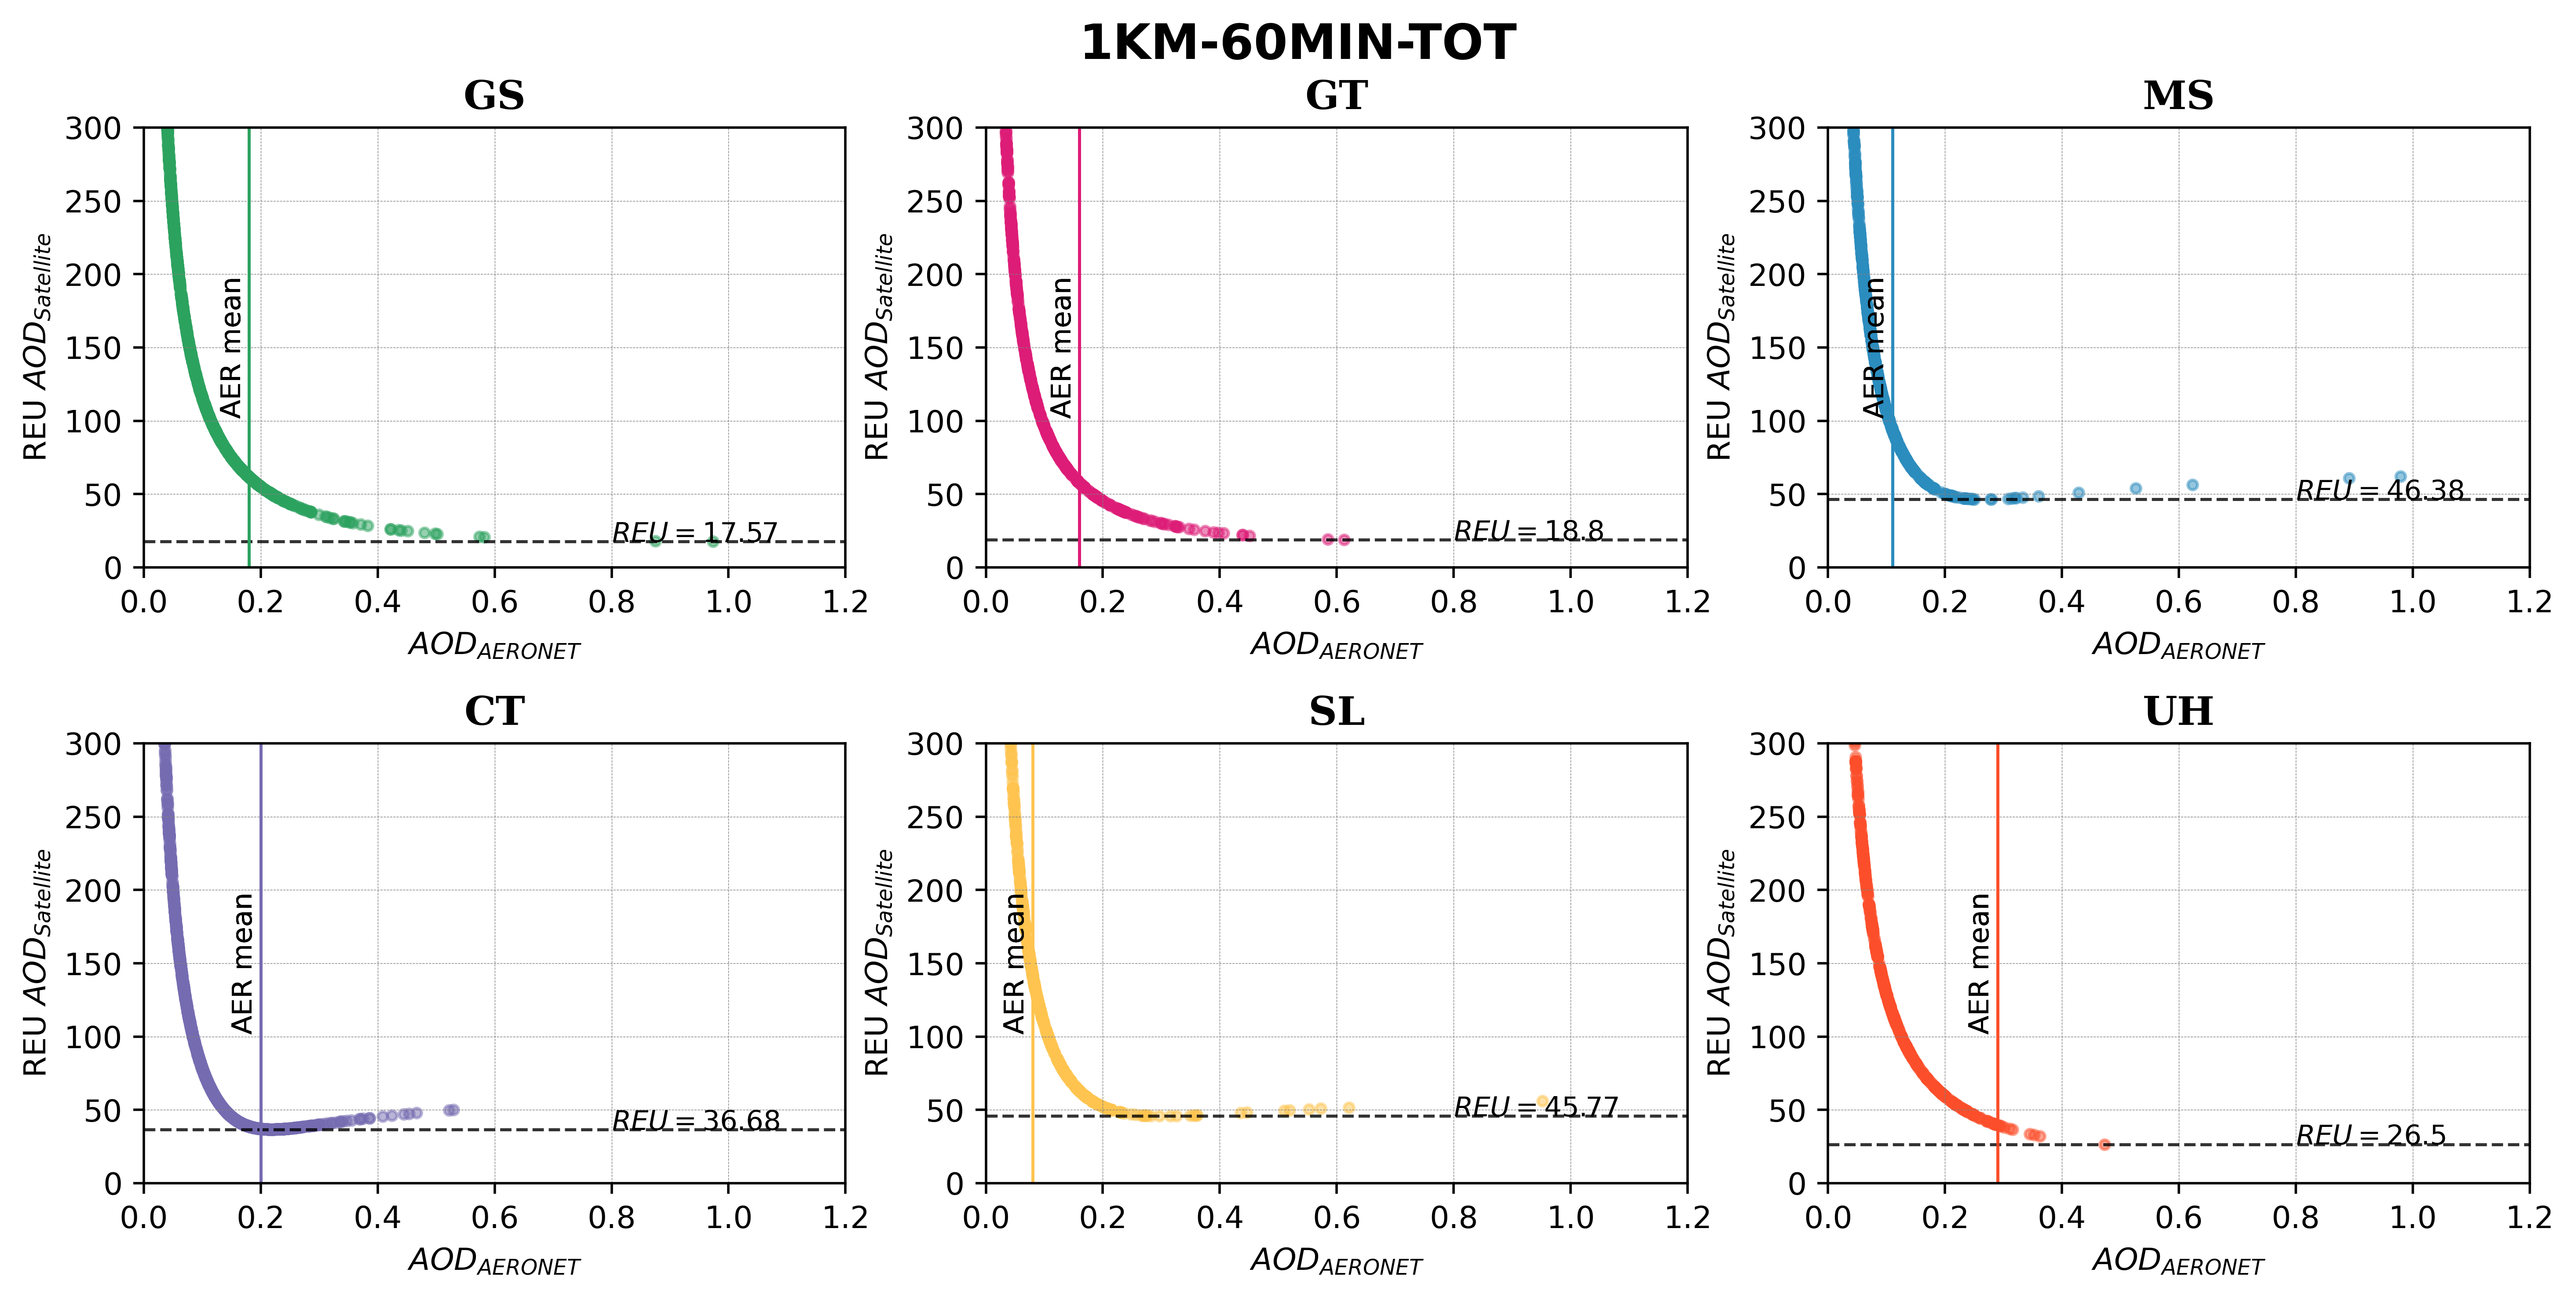

In [ ]:
# Plot de la REU en USA
resolucion_espaciotemporal = "1KM-60MIN-TOT"
color_maiac = ["#2ca25f","#dd1c77","#2b8cbe","#756bb1","#fec44f" ,"#fc4e2a"]
resolucion_espaciotemporal = "1KM-60MIN-TOT"
dir = "D:/Josefina/paper_git/paper_maiac/datasets/V02/processed/merge_BUFFER/USA_C61/horario/1km_v2/"
date = "%d/%m/%Y"
REU_plot(path=dir,date_format=date,nrows=2,ncols=3,color_maiac = color_maiac,plot = 'LALAL',resolucion_espaciotemporal=resolucion_espaciotemporal)
